In [3]:
# Import functions and libraries
import numpy as np, matplotlib.pyplot as plt
import threading,time, queue, pyaudio 
from matplotlib.pyplot import *
import matplotlib.cm as cm
from scipy import signal
from threading import Lock
from __future__ import division
import math

%matplotlib inline

## Part 1: Chirping!

In [4]:
fs = 48000
f0 = 20
f1 = 20000
T = 10
# your code here
# generate time index and phase
t = np.linspace(0, 10, num = 10*fs)
phi_of_t = 2*np.pi*t*(f0+(f1-f0)*t/(2*T))
# generate chirp signal
s_chirp = 0.5*np.sin(phi_of_t)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


Text(0.5,0,'time')

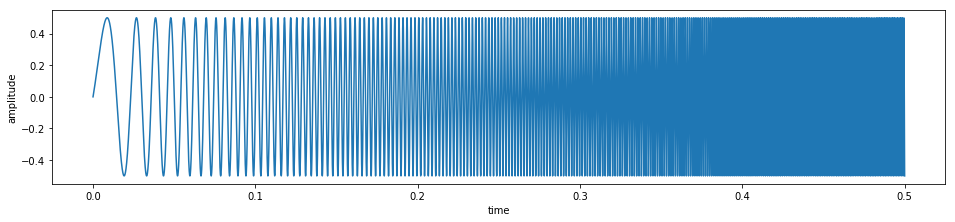

In [5]:
# Set the aspect ratio such that the image is wide
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))

obs_time = np.linspace(0, 0.5, 0.5*fs)
phi_of_t1 = 2*np.pi*obs_time*(f0+(f1-f0)*obs_time/(2*T))

# generate chirp signal
result = 0.5*np.sin(phi_of_t1)

# plot the graph
plt.plot(obs_time, result)
plt.ylabel( "amplitude" )
plt.xlabel( "time" )

* In the above graph, we can see that the frequency of the singal is increasing with the time increasing, for the reason that the instantaneous frequency is increasing with the time.

Text(0.5,0,'Normalized frequency')

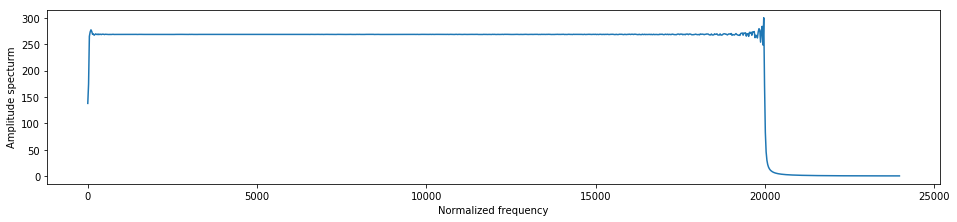

In [6]:
# # generate frequency response of chirp
normalized_freq, amp = signal.freqz(s_chirp,a=1,worN = 1024)

# generate frequency index
w = normalized_freq/(2*np.pi)*48000

# plot the graph
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))

plt.plot(w, abs(amp))
plt.ylabel("Amplitude specturm")
plt.xlabel("Normalized frequency")

#### Observation
The chirped signal is acting like a window function, and to analyze the normal signal, we need to truncate the signal for further analysis by using the window function. The purpose of window functions in signal processing is to remove extraneous information, so that subsequent analysis produces more meaningful results. Windows functions do pre-processioning in the time domain to help improve results of later processing in the frequency domain.
___

In [7]:
def play_audio( Q, p, fs , dev=None):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data is "EOT" :
            break
        try:
            ostream.write( data.astype(np.float32).tostring() )
        except:
            break
            
def record_audio( Queue, p, fs ,dev=None,chunk=2048,lock=None):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) #
    # p.terminate() # terminate pyAudio
    
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is destroyed, stops
            with lock if lock is not None else 1:
                data_str = istream.read(chunk, exception_on_overflow=False) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        Queue.put( data_flt ) # append to list

def xciever(sig, fs):
    # function takes a signal and a sampling frequency
    # it then plays and records at the same time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input output FIFO queues
    Qin = queue.Queue()
    Qout = queue.Queue()

    #lock for controlling access to shared resources
    lock = Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})
    t_play_audio = threading.Thread(target = play_audio,  args = (Qout, p, fs  ))

    # start the recording and playing threads
    t_rec.start()
    t_play_audio.start()

    Qout.put( sig );
    Qout.put( "EOT" );

    # pause for RECORD_SECS seconds
    RECORD_SECS = len(sig)/fs + 2.0
    time.sleep( RECORD_SECS )
    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )

    return rcv

In [132]:
## Play and record chirp at the same time

fs = 48000 # sampling rate = 48000 Hz

rcv_chirp = xciever( s_chirp, fs) # Qin = queue.Queue() Qout = queue.Queue() / Note: queue instead of Queue for python3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


<IPython.core.display.Javascript object>


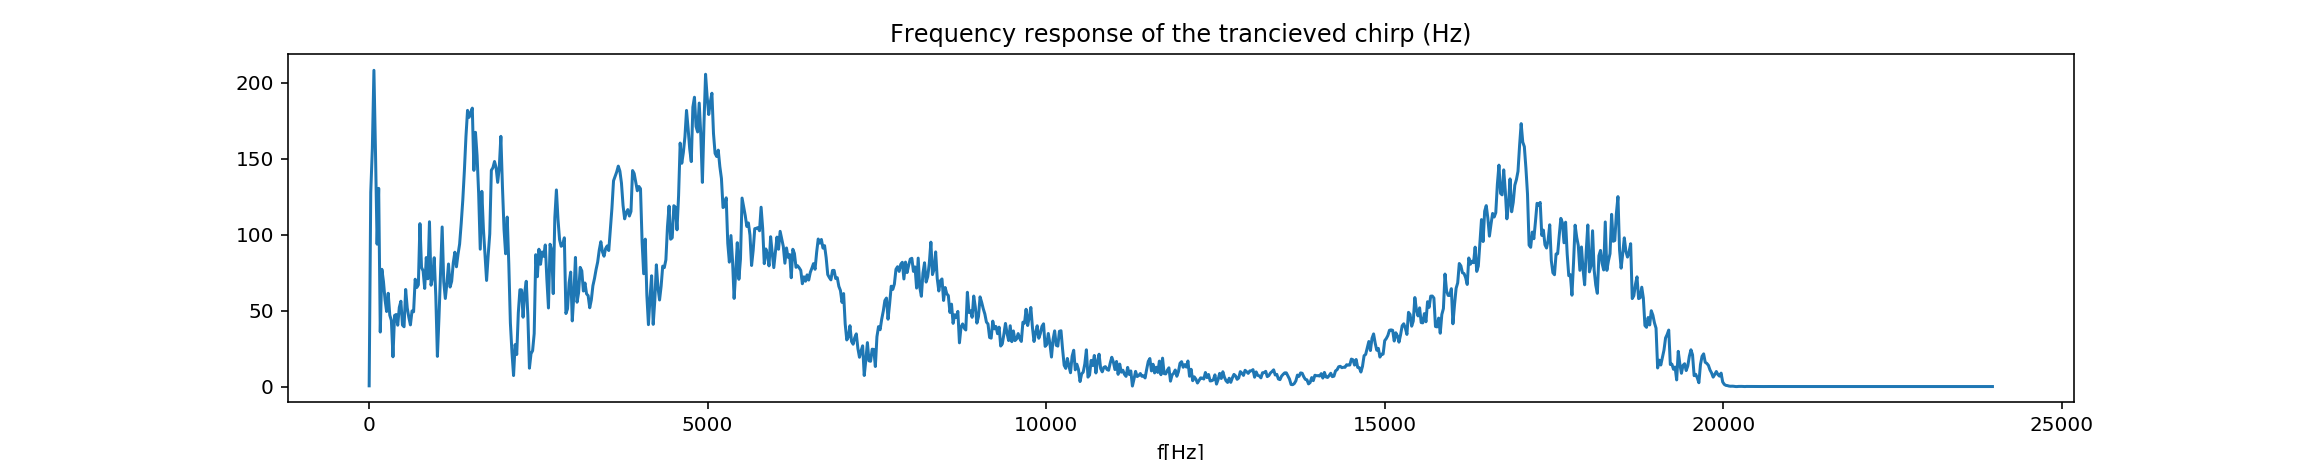

<IPython.core.display.Javascript object>


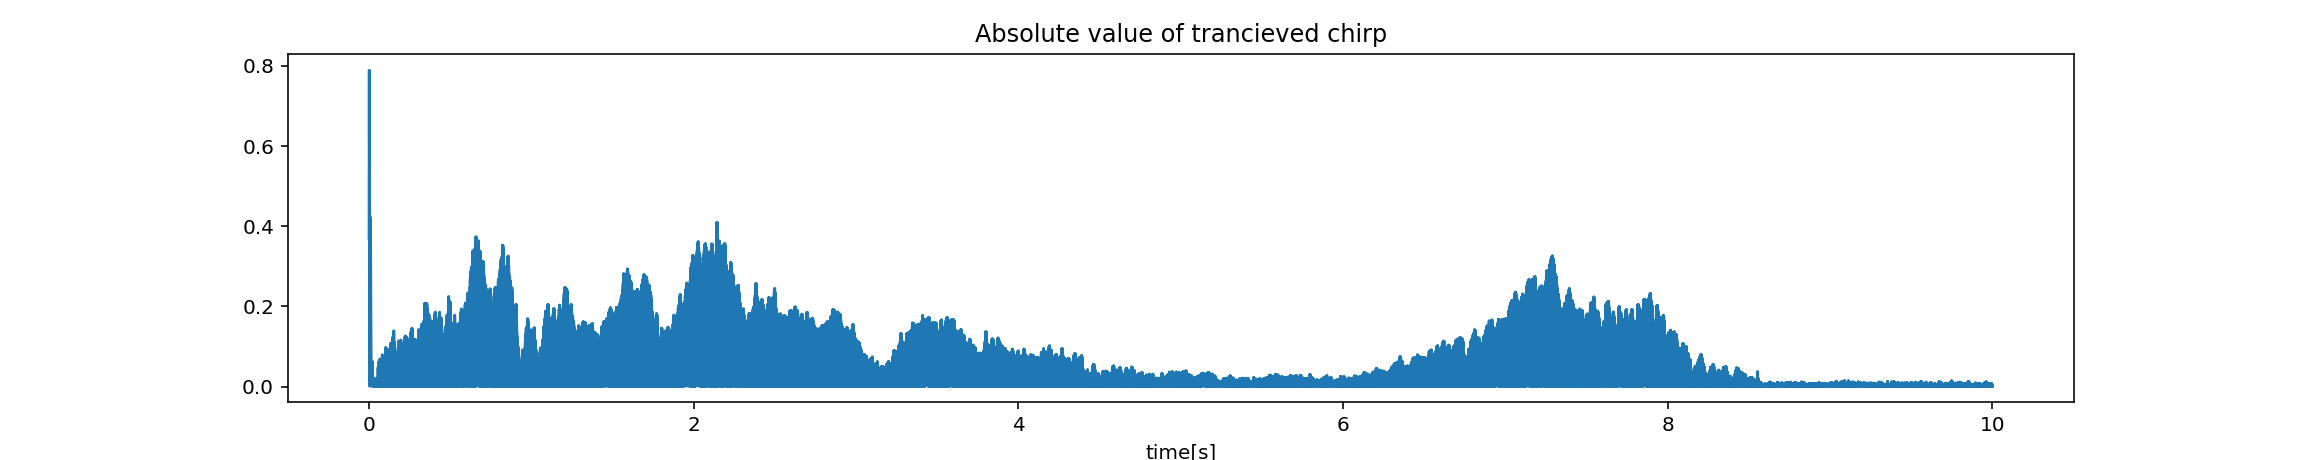

Text(0.5,0,'time[s]')

In [133]:
## Plot chirp response

# generate frequency response of recorded chirp
norm_freq, RCV_chirp = signal.freqz(rcv_chirp, a=1, worN = 1024)

# generate frequency index
f = norm_freq/(2*np.pi)*48000

# generate a time index from 0s to 10s
t = np.linspace(0, 10, len(rcv_chirp))

# free code for your plot:
width, height = figaspect(0.2)
fig1 = figure(figsize=(width,height))
plt.plot(f, np.abs(RCV_chirp))
plt.title('Frequency response of the trancieved chirp (Hz)')
plt.xlabel('f[Hz]')

fig1 = figure(figsize=(width,height))
plt.plot(t, np.abs(rcv_chirp))
plt.title('Absolute value of trancieved chirp')
plt.xlabel('time[s]')

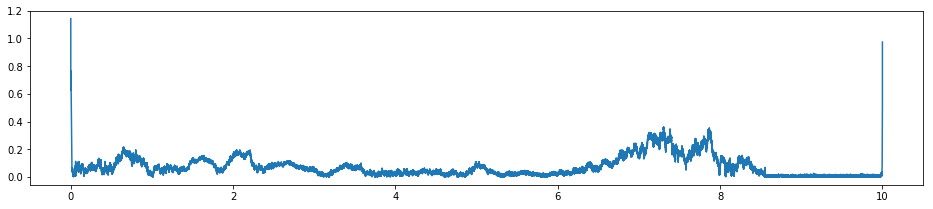

In [10]:
# Get the analytic signal
analytic_signal = signal.hilbert(rcv_chirp)

# Get the absolute value
amplitude_envelope = np.abs(analytic_signal)

# Set the time period
t = np.linspace(0, 10, len(rcv_chirp))

# Plot the graph
width, height = figaspect(0.2)
fig1 = figure(figsize=(width,height))
plt.plot(t, amplitude_envelope)

### Auto-correlation Properties of the Chirp:

In part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = (x[m]*y^*[-m])[n]$$

, where $y^*[-m]$ is the complex conjugat of $y[-m]$. This similar to a convolution, without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals is at position $n$, the higher the value will be. That's why it is useful in a sonar system.

#### Matched filter 
When we look for a very specific shape in a signal, we can comput a cross correlation between the signal and the shape we are interested in. In that case, the operation of the cross correlation is also called a matched filter -- i.e. correlating with a filter that is matched to the shape we look for. 

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the auto-correlation, which is basically a cross correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its auto-correlation is very narrow. Since the spread of the resulting correlation determines how fast you can detect, the width of the auto-correlation is important. This property is called pulse compression and is widely considered in radar design. Random noise and some other pseudo-random like sequences also possess this property. 

<IPython.core.display.Javascript object>


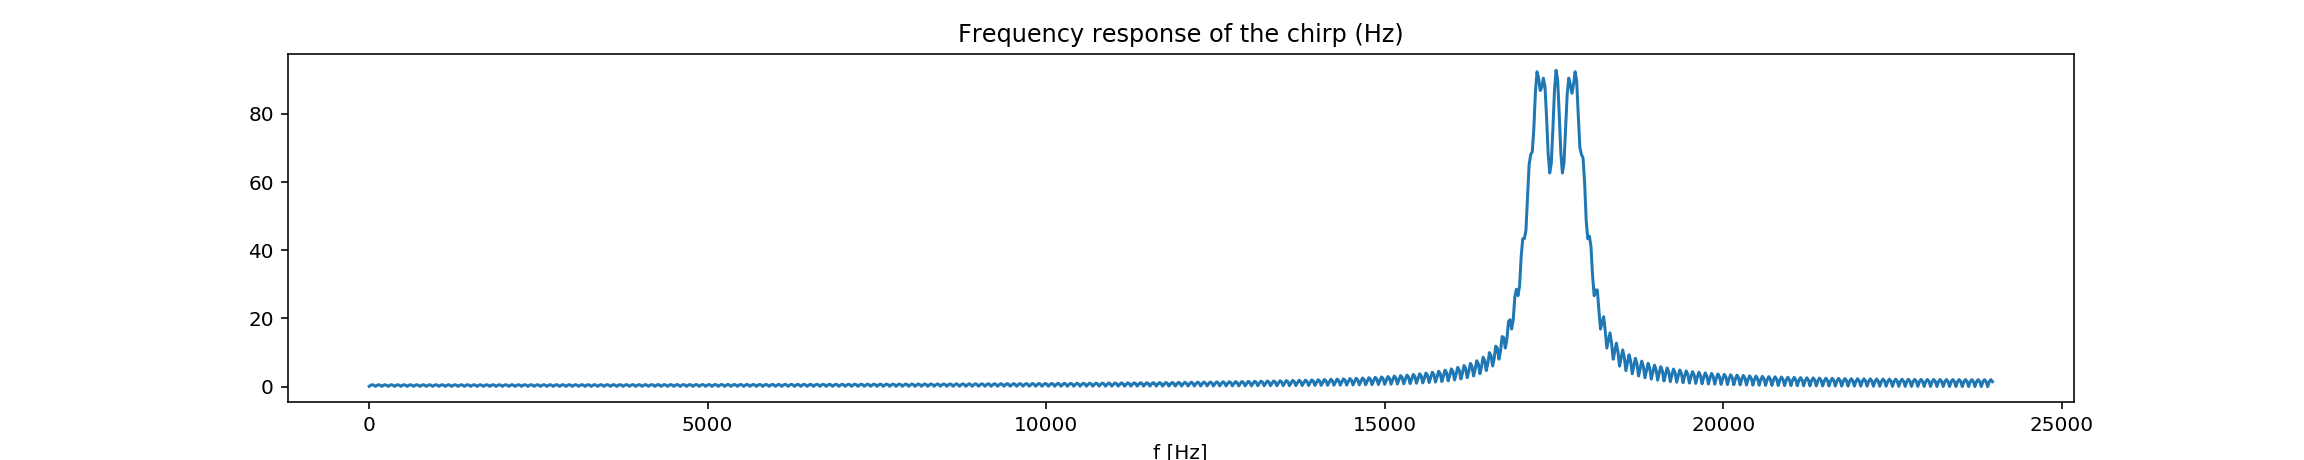

In [5]:
fs = 48000
f0 = 17000
f1 = 18000
N = 512 # number of samples
T = N/fs # time interval

# generate time index and phase value
t = np.linspace(0, T, N)
phi_of_t = 2*np.pi*t*(f0+(f1-f0)*t/(2*T))

# generate chirp signal
s_chirp = np.sin(phi_of_t)

# generate frequency response of chirp
norm_freq, amp = signal.freqz(s_chirp, a=1, worN = 1024)
f = norm_freq*fs/(2*np.pi)

# plot the graph
width, height = figaspect(0.2)
fig1 = figure(figsize=(width,height))
plt.title('Frequency response of the chirp (Hz)')
plt.xlabel('f [Hz]')
plt.plot(f, abs(amp))


<IPython.core.display.Javascript object>


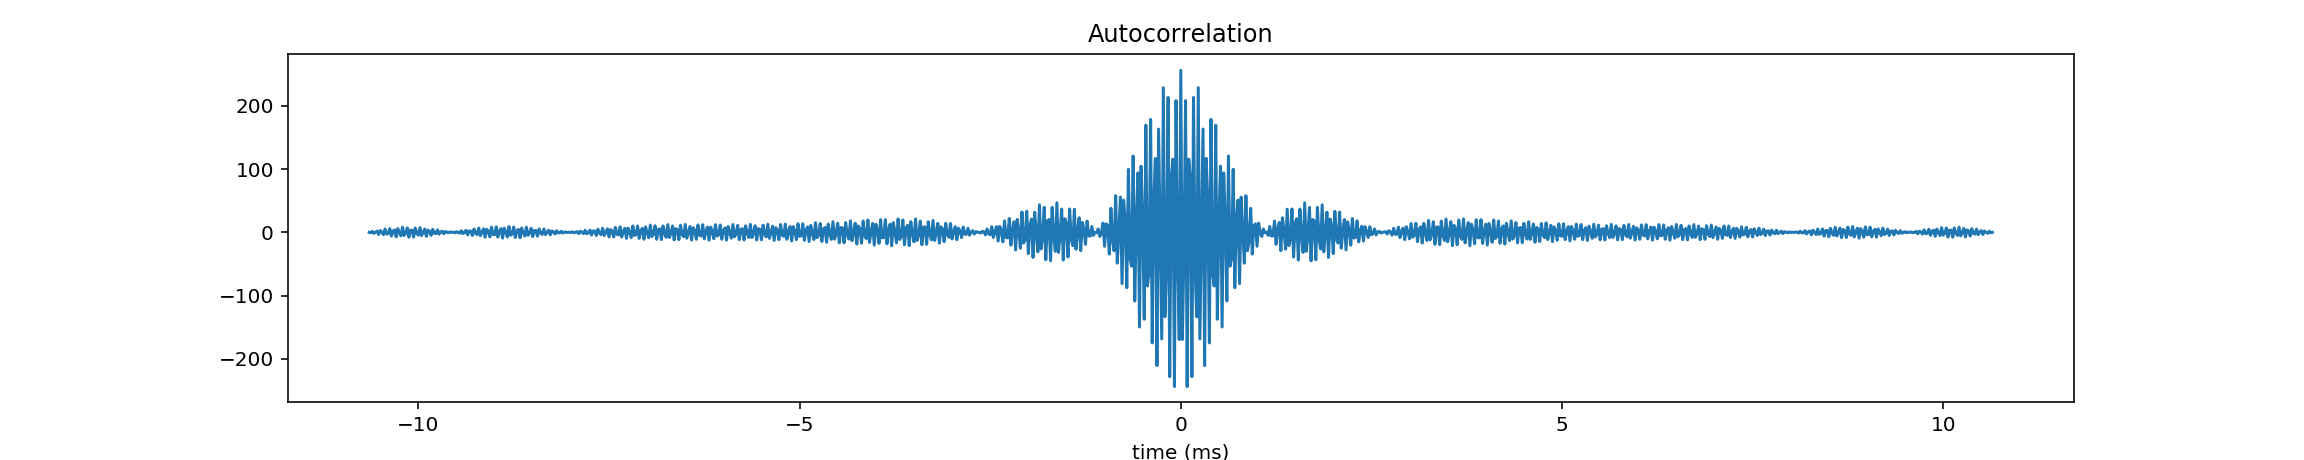

In [67]:
# Autocorrelation using the fftconvolve
autocorr = signal.fftconvolve(s_chirp, s_chirp[::-1], mode='full')

# Transfer unit to ms
unit = 1000/48000

# Plot the graph 
width, height = figaspect(0.2)
fig1 = figure(figsize=(width,height))
plt.title('Autocorrelation')
plt.xlabel('time (ms)')

# Set the time interval length the same as the length of the signal
plt.plot(np.arange(-len(s_chirp)+1,len(s_chirp))*unit, autocorr)


##### Observation: 
The idea of autocorrelation is to provide a measure of similarity between a signal and itself at a given lag. We step through the signal sample-by-sample and perform a correlation between the reference window and the lagged window. The correlation at "0 ms" (lag 0) will be the global maximum because you're comparing the reference to a verbatim copy of itself. As you step forward, the correlation will necessarily decrease, but in the case of a periodic signal.

<IPython.core.display.Javascript object>


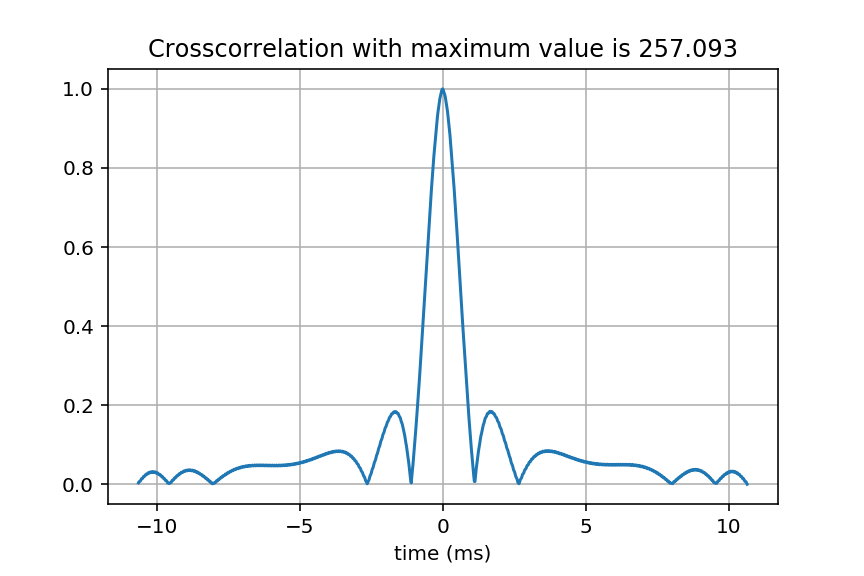

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'time (ms)')

In [8]:
%matplotlib notebook

# the analytic function of the chirp
s_chirp_a = np.exp(1j*phi_of_t) 

# Compute the crosscorrelation
crosscorr = signal.fftconvolve(s_chirp_a, s_chirp[::-1], mode='full')
maximum_val = max(abs(crosscorr))

# Transfer unit to ms
unit = 1000/48000

# Plot the graph
plt.plot(np.arange(-len(s_chirp_a)+1,len(s_chirp))*unit, abs(crosscorr)/maximum_val)
plt.grid('on')
plt.title('Crosscorrelation with maximum value is 257.093')
plt.xlabel('time (ms)')
# 257.305 is the maximum value, so the half will be 128.6525 with x = -29.501 and x = 29.7504

<IPython.core.display.Javascript object>


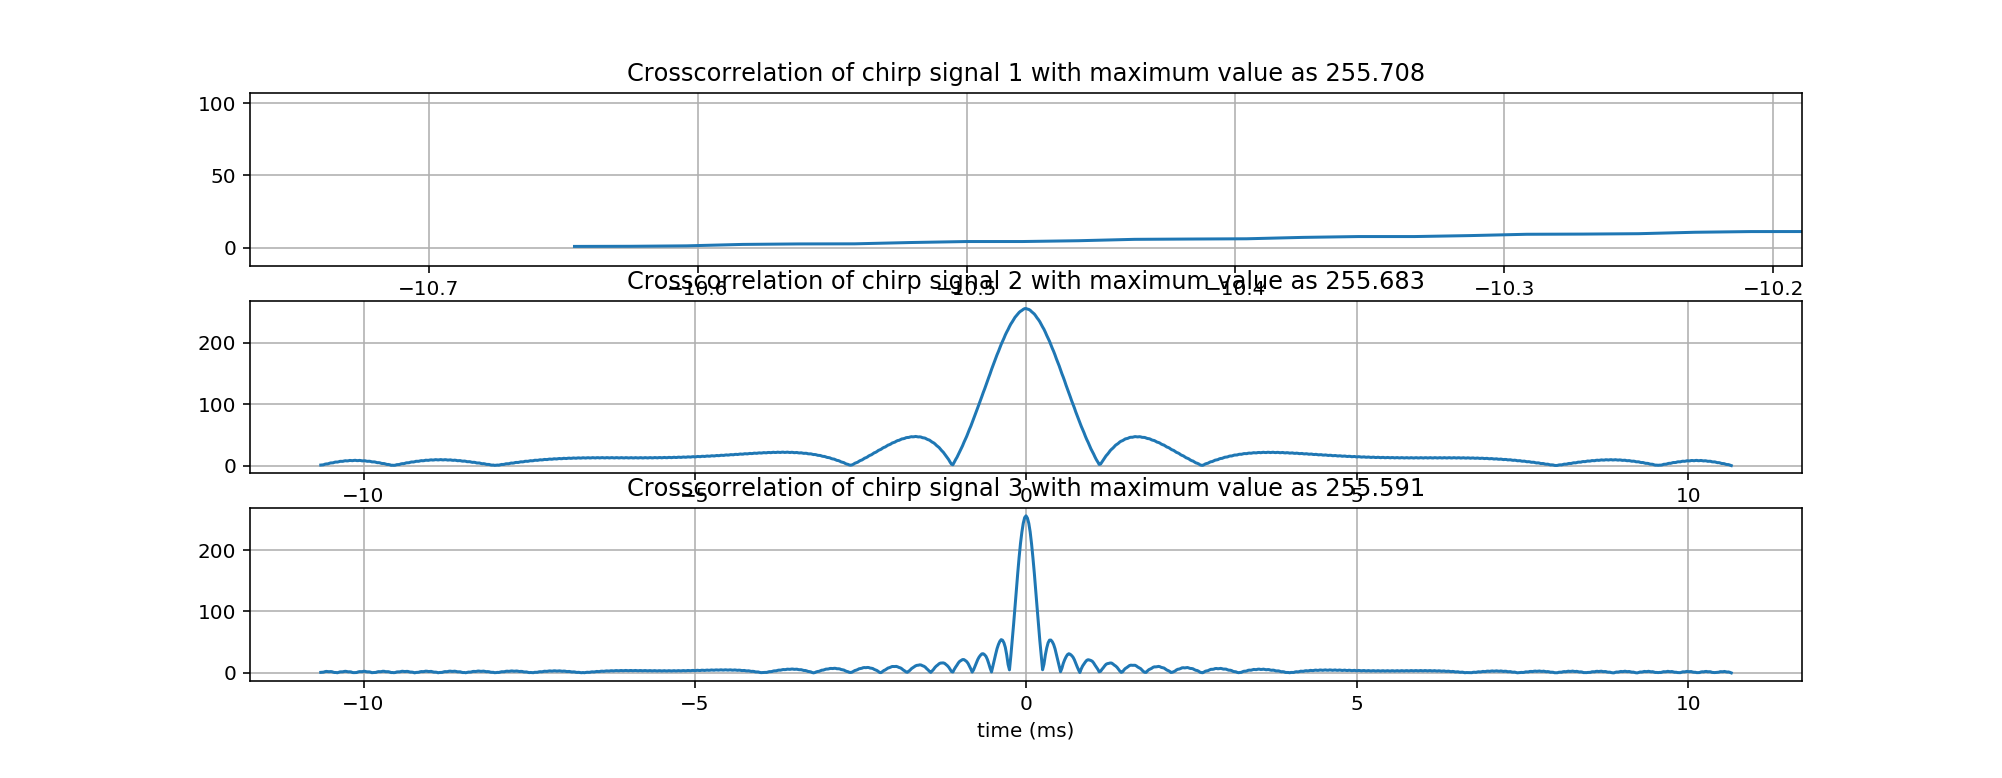

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [9]:
%matplotlib notebook

# 1. A constant frequency of 17000Hz, 512 samples in length
fs_1 = 48000
f0_1 = 17000
f1_1 = 17000
N1 = 512
T1 = N1/fs_1
t1 = np.linspace(0, T1, N1)
phi_of_t1 = 2*np.pi*t1*(f0_1+(f1_1-f0_1)*t1/(2*T1))
s_chirp1 = np.sin(phi_of_t1) # chirp signal 1

# 2. A chirp with a frequency sweep from 16500Hz - 17500Hz (1KHz Bandwidth), 512 in length
fs_2 = 48000
f0_2 = 16500
f1_2 = 17500
N2 = 512
T2 = N2/fs_2
t2 = np.linspace(0, T2, N2)
phi_of_t2 = 2*np.pi*t2*(f0_2+(f1_2-f0_2)*t2/(2*T2))
s_chirp2 = np.sin(phi_of_t2) # chirp signal 2

# 3. A chirp with a frequency sweep from 15000Hz - 19000Hz (4KHz Bandwidth), 512 in length
fs_3 = 48000
f0_3 = 15000
f1_3 = 19000
N3 = 512
T3 = N3/fs_3
t3 = np.linspace(0, T3, N3)
phi_of_t3 = 2*np.pi*t3*(f0_3+(f1_3-f0_3)*t3/(2*T3))
s_chirp3 = np.sin(phi_of_t3) # chirp signal 3


s_chirp_a1 = np.exp(1j*phi_of_t1) # the analytic function of the chirp
s_chirp_a2 = np.exp(1j*phi_of_t2) # the analytic function of the chirp
s_chirp_a3 = np.exp(1j*phi_of_t3) # the analytic function of the chirp

crosscorr_1 = signal.fftconvolve(s_chirp_a1, s_chirp1[::-1], mode='full')
crosscorr_2 = signal.fftconvolve(s_chirp_a2, s_chirp2[::-1], mode='full')
crosscorr_3 = signal.fftconvolve(s_chirp_a3, s_chirp3[::-1], mode='full')

# Transfer unit to ms
unit = 1000/48000

# help with plot
width, height = figaspect(0.2)
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(width,height))

ax1.plot(np.arange(-len(s_chirp_a1)+1,len(s_chirp1))*unit, abs(crosscorr_1))
ax2.plot(np.arange(-len(s_chirp_a2)+1,len(s_chirp2))*unit, abs(crosscorr_2))
ax3.plot(np.arange(-len(s_chirp_a3)+1,len(s_chirp3))*unit, abs(crosscorr_3))

ax1.set_title('Crosscorrelation of chirp signal 1 with maximum value as 255.708')
ax1.set_xlabel('time (ms)')
ax2.set_title('Crosscorrelation of chirp signal 2 with maximum value as 255.683')
ax2.set_xlabel('time (ms)')
ax3.set_title('Crosscorrelation of chirp signal 3 with maximum value as 255.591')
ax3.set_xlabel('time (ms)')

ax1.grid('on')
ax2.grid('on')
ax3.grid('on')


<IPython.core.display.Javascript object>


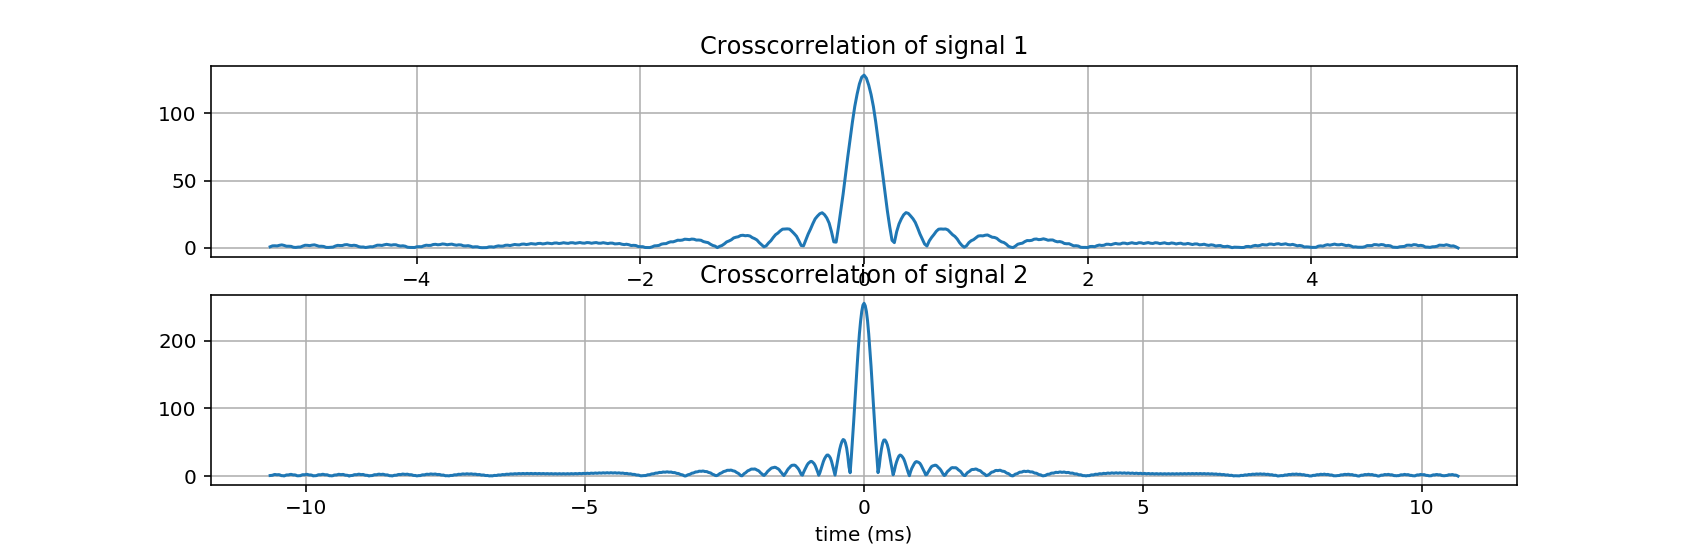

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
%matplotlib notebook

# 1. A chirp with a frequency sweep from 15000Hz - 19000Hz, 256 in length
fs_1 = 48000
f0_1 = 15000
f1_1 = 19000
N1 = 256
T1 = N1/fs_1
t1 = np.linspace(0, T1, N1)
phi_of_t1 = 2*np.pi*t1*(f0_1+(f1_1-f0_1)*t1/(2*T1))
s_chirp1 = np.sin(phi_of_t1) # chirp signal 1

# 2. A chirp with a frequency sweep from 15000Hz - 19000Hz, 512 in length
fs_2 = 48000
f0_2 = 15000
f1_2 = 19000
N2 = 512
T2 = N2/fs_2
t2 = np.linspace(0, T2, N2)
phi_of_t2 = 2*np.pi*t2*(f0_2+(f1_2-f0_2)*t2/(2*T2))
s_chirp2 = np.sin(phi_of_t2) # chirp signal 2

s_chirp_a1 = np.exp(1j*phi_of_t1) # the analytic function of the chirp
s_chirp_a2 = np.exp(1j*phi_of_t2) # the analytic function of the chirp

# Cross correlation
crosscorr_1 = signal.fftconvolve(s_chirp_a1, s_chirp1[::-1], mode='full')
crosscorr_2 = signal.fftconvolve(s_chirp_a2, s_chirp2[::-1], mode='full')

# Transfer unit to ms
unit = 1000/48000

# Plot the signal
width, height = figaspect(0.3)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(width,height))

ax1.plot(np.arange(-len(s_chirp_a1)+1,len(s_chirp1))*unit, abs(crosscorr_1))# MAX: 128.163 
ax2.plot(np.arange(-len(s_chirp_a2)+1,len(s_chirp2))*unit, abs(crosscorr_2))# MAX: 255.591

ax1.set_title('Crosscorrelation of signal 1')
ax1.set_xlabel('time (ms)')
ax2.set_title('Crosscorrelation of signal 2')
ax2.set_xlabel('time (ms)')

ax1.grid('on')
ax2.grid('on')

### Dealing with sidelobes
As can be seen, the chirp provides good pulse compression of the main-lobe. However, there exists very strong sidelobes. This is because the chirp is multiplied with a rect function, that is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes. 
    

<IPython.core.display.Javascript object>


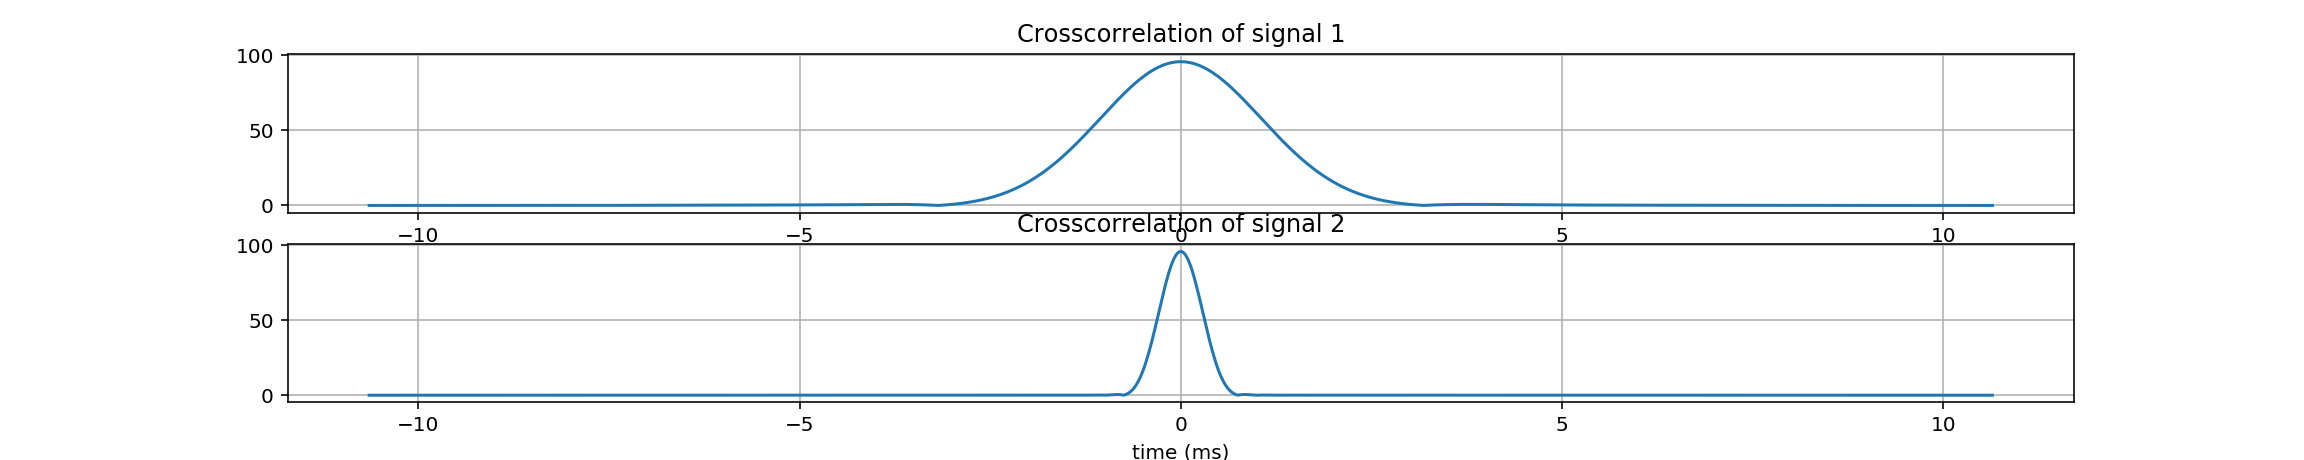

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [10]:
%matplotlib notebook

# 1. A chirp with a frequency sweep from 15000Hz - 19000Hz, 256 in length
fs_1 = 48000
f0_1 = 16500
f1_1 = 17500
N1 = 512
T1 = N1/fs_1
t1 = np.linspace(0, T1, N1)
phi_of_t1 = 2*np.pi*t1*(f0_1+(f1_1-f0_1)*t1/(2*T1))
s_chirp1 = np.sin(phi_of_t1) # chirp signal 1

# 2. A chirp with a frequency sweep from 15000Hz - 19000Hz, 512 in length
fs_2 = 48000
f0_2 = 15000
f1_2 = 19000
N2 = 512
T2 = N2/fs_2
t2 = np.linspace(0, T2, N2)
phi_of_t2 = 2*np.pi*t2*(f0_2+(f1_2-f0_2)*t2/(2*T2))
s_chirp2 = np.sin(phi_of_t2) # chirp signal 2

s_chirp_a1 = np.exp(1j*phi_of_t1) # the analytic function of the chirp
s_chirp_a2 = np.exp(1j*phi_of_t2) # the analytic function of the chirp

# Window the frequency
window = np.hanning(512)

# Windowing the signal
s_chirp1 = s_chirp1*window
s_chirp2 = s_chirp2*window
s_chirp_a1 = s_chirp_a1*window
s_chirp_a2 = s_chirp_a2*window

# Cross correlation
crosscorr_1 = signal.fftconvolve(s_chirp_a1, s_chirp1[::-1], mode='full')
crosscorr_2 = signal.fftconvolve(s_chirp_a2, s_chirp2[::-1], mode='full')

# Plot the signal
width, height = figaspect(0.2)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(width,height))

ax1.plot(np.arange(-len(s_chirp_a1)+1,len(s_chirp1))*unit, abs(crosscorr_1))
ax2.plot(np.arange(-len(s_chirp_a2)+1,len(s_chirp2))*unit, abs(crosscorr_2))

ax1.set_title('Crosscorrelation of signal 1')
ax1.set_xlabel('time (ms)')
ax2.set_title('Crosscorrelation of signal 2')
ax2.set_xlabel('time (ms)')

ax1.grid('on')
ax2.grid('on')


## Part 2: Sonar

### Generating Chirp Pulses

Recall from Part I, that the with of the main lobe of the autocorrelation depends on the bandwidth of the pulse. 
For a constant frequency pulse, the bandwidth will be inversly proportional to its length. Short pulses are localized in time, and therefore we will be able to separate echoes from targets that are close. However, short pulses carry less energy (for the same amplitude) and this will reduce our signal to noise ratio (SNR) in the detection and reduce our ability to detect the targets at all. So, in summary: for constant frequency pulse, there's an inerent tradeoff between the resolution of the sonar (distinguish between close targets) and the signal to noise ratio. 

If we use a chirp pulse, we can increase the length of the pulse while also increasing the bandwidth. This will enable us to improve our signal to noise ratio as well as keeping the resolution of our sonar (by preserving the BW).

In our implemetation we are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echos will correspond to double the time-of-flight of sound propagation from our system to the target. 

In [113]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    #     Output:
    #              pulse - chirp pulse
    
    # Set the end time value
    T = Npulse/fs
    
    # Set time interval
    t = np.linspace(0, T, Npulse, endpoint=True)
    
    # Set the phase value
    phi_of_t = 2*np.pi*(f0*t + (f1-f0)/(2*T)*np.power(t,2))
    
    # Generate the analytic pulse
    pulse = np.exp(1j*phi_of_t)
    
    # Reshape the pulse
    pulse = np.reshape(pulse, (Npulse,1))
    
    return pulse

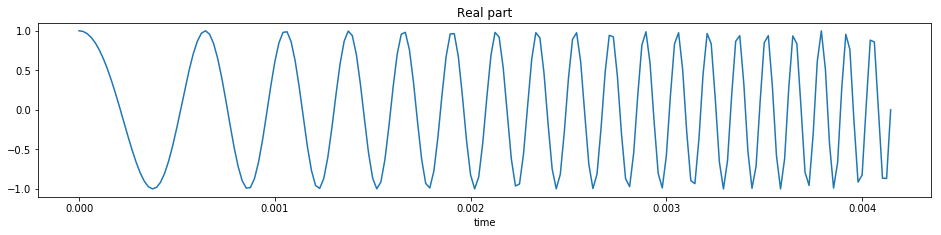

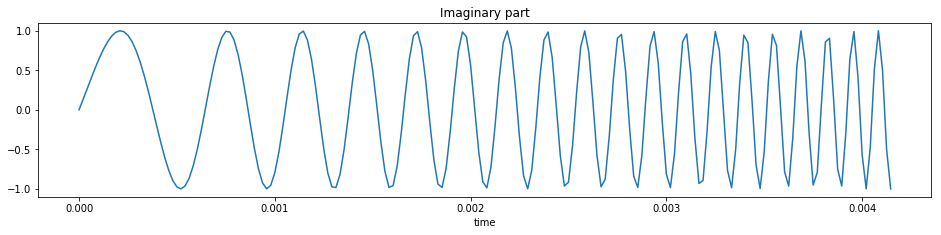

In [114]:
%matplotlib inline

# Set the variables
Npulse = 200 
f0 = 1000 
f1 = 8000
fs = 48000

# Generate the pulse using the function created
pulse = genChirpPulse(Npulse, f0, f1, fs)

# Set the time interval
t = np.r_['c', 0.0:Npulse]/fs

# Plot the real part of the pulse
width, height = figaspect(0.2)
fig1 = figure(figsize=(width,height))
plt.title('Real part')
plt.xlabel('time')
plt.plot(t, pulse.real)

# Plot the imaginary part of the pusle
fig1 = figure(figsize=(width,height))
plt.title('Imaginary part')
plt.xlabel('time')
plt.plot(t, pulse.imag)

In [115]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Funtion generates a pulse train from a pulse. 
    #Inputs:
    #    pulse = the pulse generated by genChirpPulse
    #    Nrep  =  number of pulse repetitions
    #    Nseg  =  Length of pulse segment >= length(pulse)

    # Padding the length of the pulse in case that Nseg is larger than len(pulse)
    Nzeros = Nseg-len(pulse) # number of zeros
    Arr_zero = np.zeros(Nzeros) # creating the array of zeros
    pulse_padding = np.append(pulse, Arr_zero)
    
    # Repeat the pulses
    ptrain = np.tile(pulse_padding, Nrep)
    
    # Reshape the pulse
    ptrain = np.reshape(ptrain, (len(ptrain),1))
    
    return ptrain

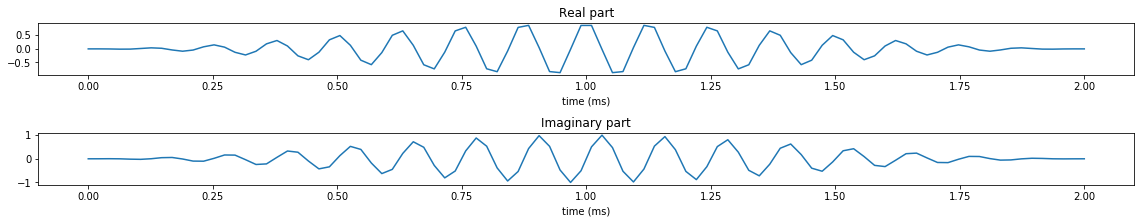

In [116]:
fs = 48000
f0 = 8000
f1 = 8000
Npulse = 96

# Set the time interval
t = np.linspace(0, Npulse/fs, Npulse, endpoint=True)

# Generate chirp pulse
pulse = genChirpPulse(Npulse, f0, f1, fs)

# Create the window
hanWin = np.hanning(Npulse)
hanWin = np.reshape(hanWin, (Npulse,1))

# Filter the signal
new_pulse = np.multiply(pulse,hanWin)

# Plot
width, height = figaspect(0.2)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(width,height))

ax1.plot(t*1000, new_pulse.real)
ax2.plot(t*1000, new_pulse.imag)

ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')
ax1.set_title('Real part')
ax2.set_title('Imaginary part')

fig1.tight_layout()

In [94]:
Nrep = 15
Nseg = 4096

# Real part of new_pulse
real_pulse = np.real(new_pulse)

# Pulse train
ptrain = genPulseTrain(real_pulse, Nrep, Nseg)


In [95]:
rcv = xciever(ptrain/2.0, fs) 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


<IPython.core.display.Javascript object>


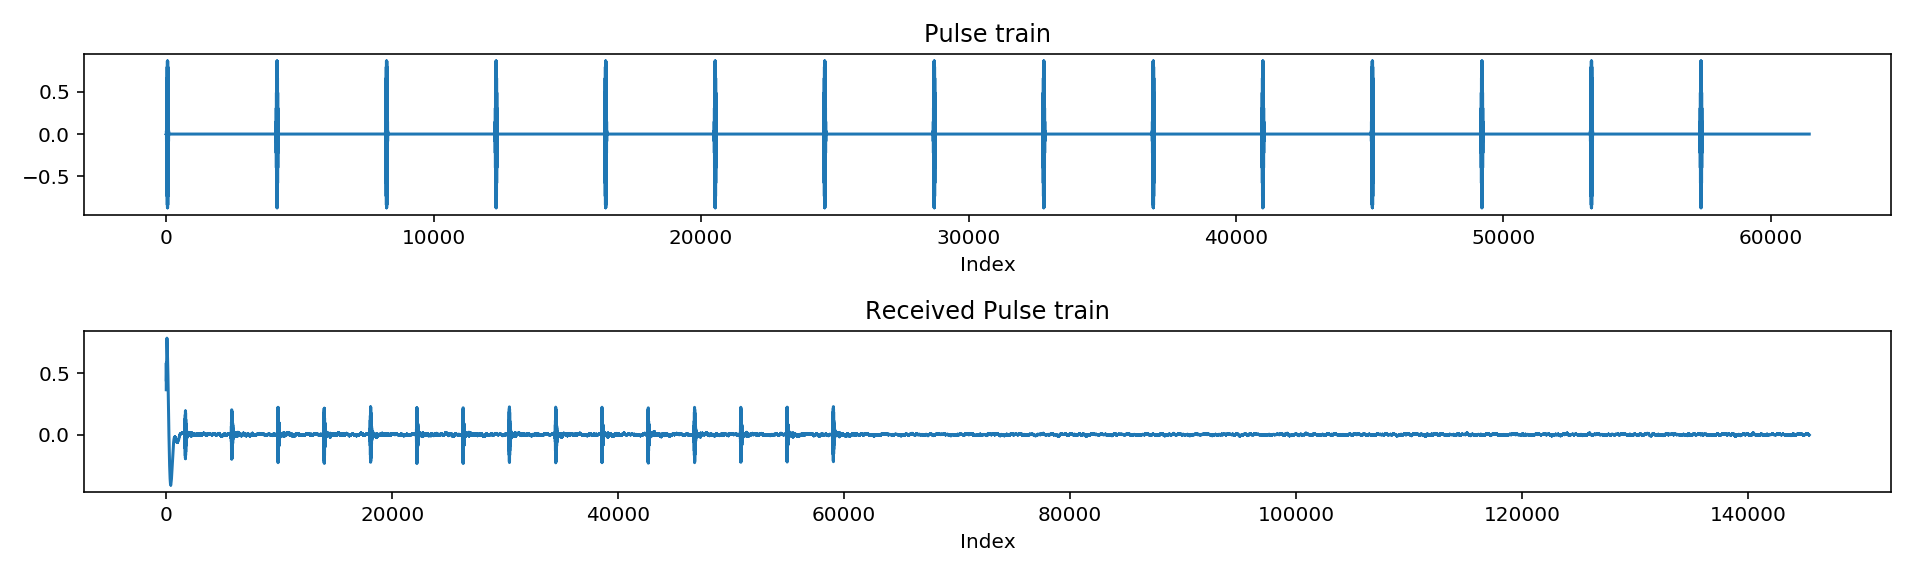

In [117]:
%matplotlib notebook

# Reshape the received signal
rcv = np.reshape(rcv, (len(rcv),1))

# Plot the graph
width, height = figaspect(0.3)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(width,height))


ax1.plot(ptrain)
ax1.set_title('Pulse train')
ax1.set_xlabel('Index')

ax2.plot(rcv)
ax2.set_title('Received Pulse train')
ax2.set_xlabel('Index')

fig1.tight_layout()

<IPython.core.display.Javascript object>


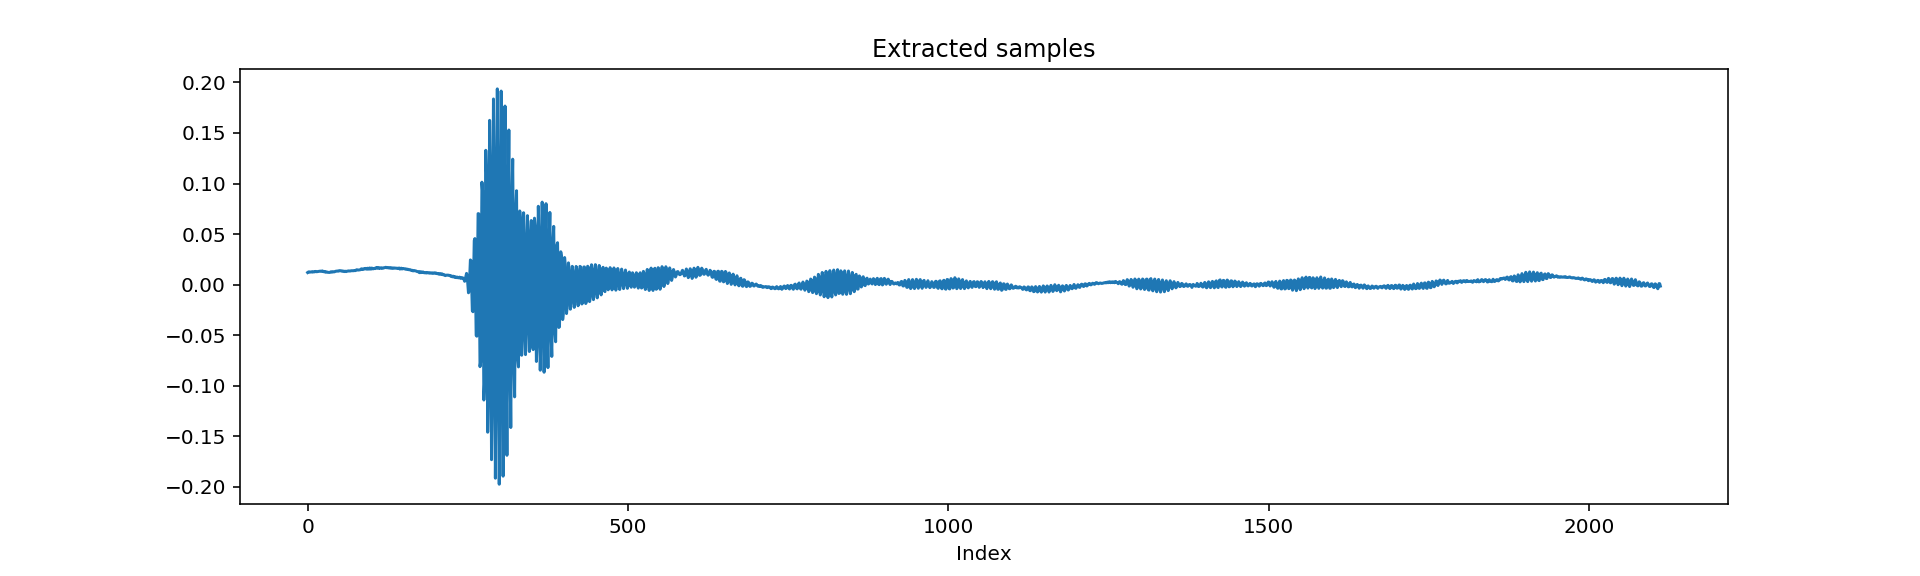

Text(0.5,0,'Index')

In [118]:
%matplotlib notebook
# find index of start pulse pf pulse train and the value of idx always changes when running the program
idx = 1595
rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]

# make plot
width, height = figaspect(0.3)
fig1 = figure(figsize=(width,height))
plt.plot(rcv_pulse)

plt.title('Extracted samples')
plt.xlabel('Index')

#### Observation:
We can clearly see there is a large pulse between 0 and 500, which is the echo returned. The echo decays to 0 with time being.

In [119]:
def crossCorr( rcv, pulse_a ):
    # Funtion generates cross-correlation between rcv and pulse_a
    # Inputs:
    #    rcv - received signal
    #    pulse_a - analytic pulse
    # Output:
    #    Xrcv - cross-correlation between rcv and pulse_a
    
    # Reshape the received signal
    rcv = np.reshape(rcv, (len(rcv),1) )
    
    # Cross correlation
    Xrcv = signal.fftconvolve(rcv, np.conj(pulse_a[::-1]), mode='full')
    
    return Xrcv
 

<IPython.core.display.Javascript object>


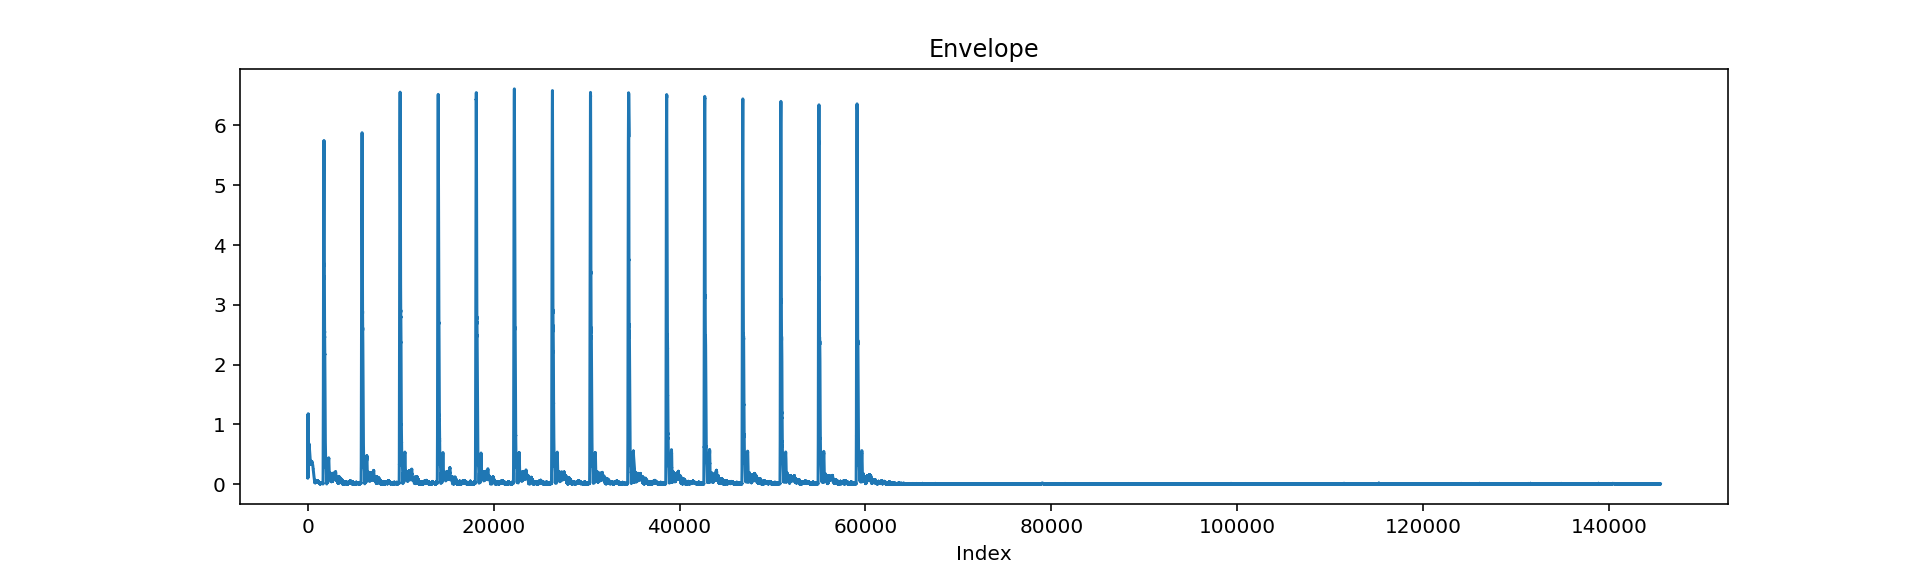

Text(0.5,0,'Index')

In [120]:
%matplotlib notebook

# Generate the cross correlation
Xrcv = crossCorr( rcv, pulse )

# Take the absolute value
Xrcv_a = abs(Xrcv)

# Plot the signal
width, height = figaspect(0.3)
fig1 = figure(figsize=(width,height))
plot(Xrcv_a)

plt.title('Envelope')
plt.xlabel('Index')

<IPython.core.display.Javascript object>


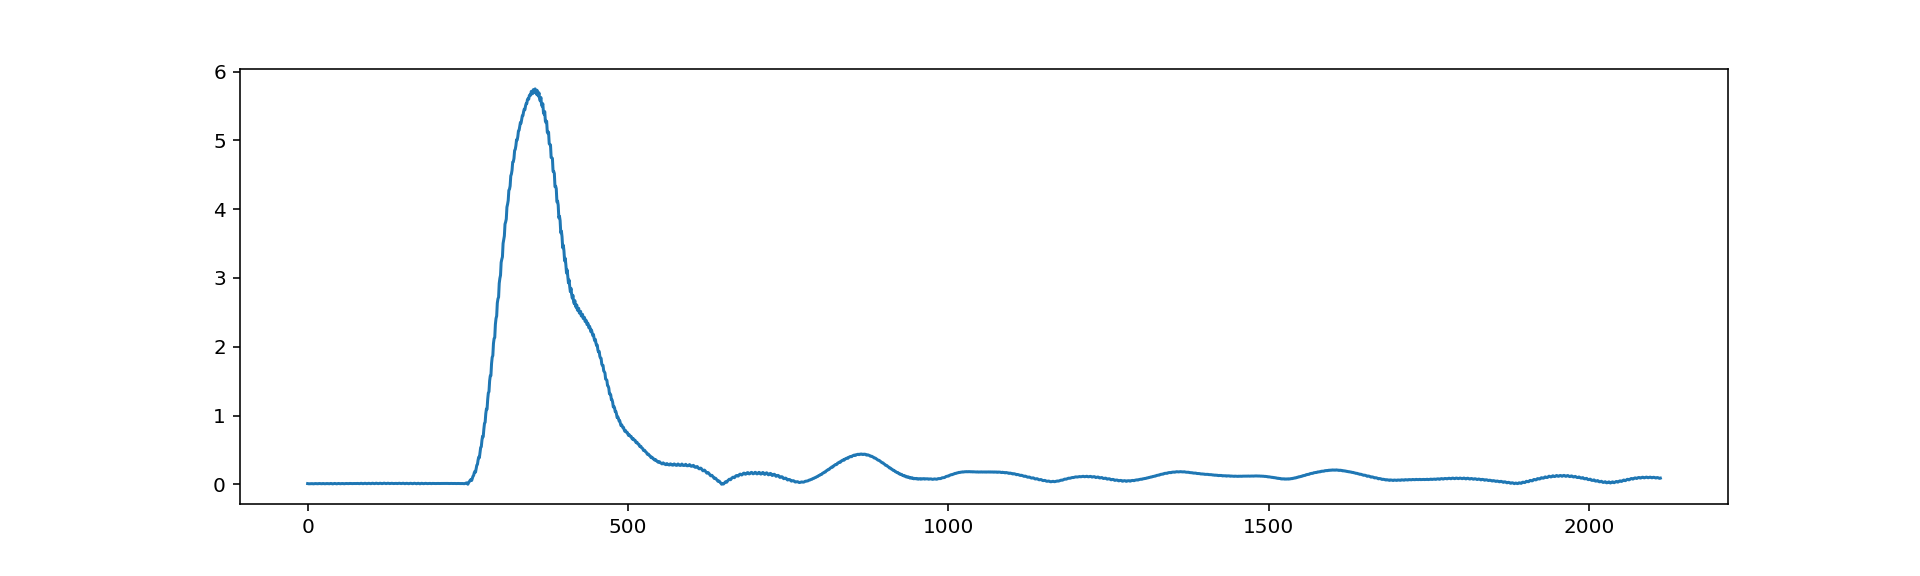

In [122]:
%matplotlib notebook

# Use the same index as previous
idx = 1595
rcv_pulse = Xrcv_a[idx-2*Npulse:idx+Npulse*20]

# make plot
width, height = figaspect(0.3)
fig1 = figure(figsize=(width,height))
plt.plot(rcv_pulse)

#### Observation:
We can still see some echoes from the signal graph. When I recorded this sound, I was quite near a wall, so the time when pulse occurred is quite quick, and this the why there is large pulse between 0 and 500.

In [56]:
def findDelay(Xrcv, Nseg):
    # finds the first pulse
    # Inputs:  
    #         Xrcv - the received matched filtered signal
    #         Nseg - length of a segment
    # Output:
    #          idx - index of the beginning of the first pulse
    
    val = np.max(abs(Xrcv))*0.9 # Taking 0.8 as I found there was a sudden decrease between 0.8 and 0.9, so I took 0.8
    
    idx = np.argmax(abs(Xrcv) > val)
    
    return idx
    

In [57]:
idx = findDelay(Xrcv_a, Nseg)
print(idx)

1685


We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}~,$$ 

where T is the temperature in degree celcius. 

In [123]:
def dist2time( dist, temperature=21):
    # Converts distance in cm to time in secs
    # Inputs:
    # dist        - distance to object in cm
    # temperature - in celcius
    # Output:
    # t           - time in seconds between transmitted pulse and echo
    
    # Generate the speed
    vs = 331.5*np.sqrt(1 + temperature/273.15)
    
    # Get the time
    t = 2*(dist/100)/vs
    
    return t
    
def  time2dist(t,temperature=21):
    # Converts time in seconds to distance in cm
    # Inputs:
    # t        - time of echo
    # temperature - in celcius
    # Output:
    # dist          - distance in cm of the target
    
    # Generate the speed
    vs = 331.5*math.sqrt(1 + temperature/273.15)
    
    # Get the distance
    dist = t*vs*100/2
    
    return dist

In [124]:
t = dist2time(400, 20)
print(t)

dist = time2dist(t, 20)
print(dist)

0.02329496742157036
400.0


## A sonar (almost)

* The following function will use previous functions to generate pulses and display the matched filtering of each pulse as intensity of a horizontal line in an image.


In [125]:
def sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg):
    pulse_a = genChirpPulse(Npulse, f0, f1, fs)
    hanWin = np.hanning(Npulse)
    
    hanWin = np.reshape(hanWin, (Npulse,1))
    pulse_a = np.multiply(pulse_a,hanWin)
    
   
    pulse = np.real(pulse_a)
    ptrain = genPulseTrain(pulse, Nrep, Nseg)
    rcv = xciever(ptrain/2.0 , fs) 
    Xrcv_a = abs( crossCorr(rcv, pulse_a) )
    Xrcv_a = np.reshape(Xrcv_a, (1,len(Xrcv_a)))
    
    idx = findDelay(Xrcv_a,Nseg) 
    img = np.zeros((Nrep,Nseg))
    img[0,:] = Xrcv_a[0,idx:idx+Nseg]
    
    # Look for peak in each pulse in the pulse train to avoid drift between xmit and receive
    for n in range(1,Nrep):
       idxx = findDelay(Xrcv_a[0,idx+int(Nseg/2):idx+int(Nseg/2)+Nseg],Nseg)
       idx = idx + idxx + int(Nseg/2)
       img[n,:]=Xrcv_a[0,idx:idx+Nseg]
        
    
    return img


In [126]:
Npulse = 72
f0 = 8000
f1 = 8000
fs = 48000
Nrep = 100
Nseg = 4800

img = sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


<IPython.core.display.Javascript object>


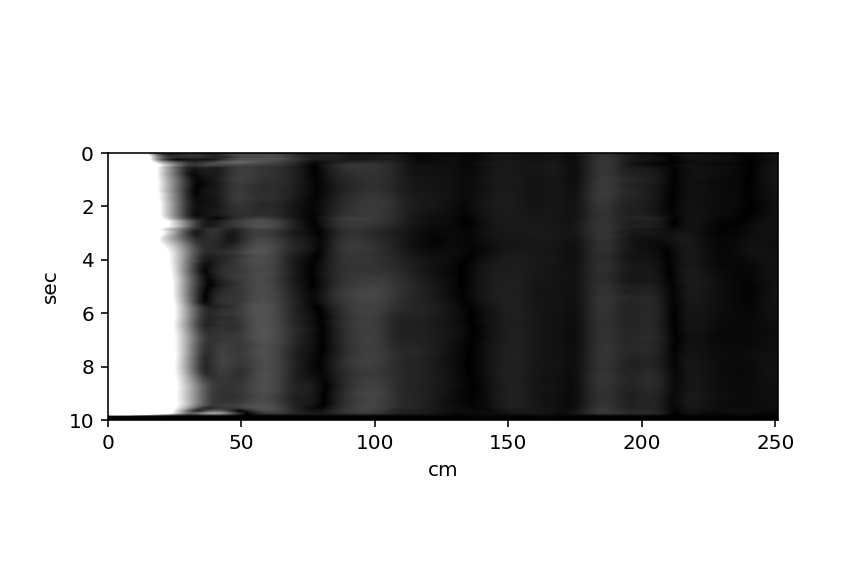

Text(0,0.5,'sec')

In [127]:
%matplotlib notebook
%matplotlib notebook

# display up to 2.5m approximately 700 samples at 21 degrees C in 48000 sampling rate

vmax = 0.3 # threshold -- lower will be able to see smaller echos

plt.imshow(img[:,0:700]/max(img.ravel()),vmax=vmax, aspect=10,cmap='gray',interpolation='bilinear',extent=(0,time2dist(700/48000),Nrep*Nseg/fs,0))
plt.xlabel('cm')
plt.ylabel('sec')

In [130]:
Npulse = 72*5
f0 = 6000
f1 = 12000
fs = 48000
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


<IPython.core.display.Javascript object>


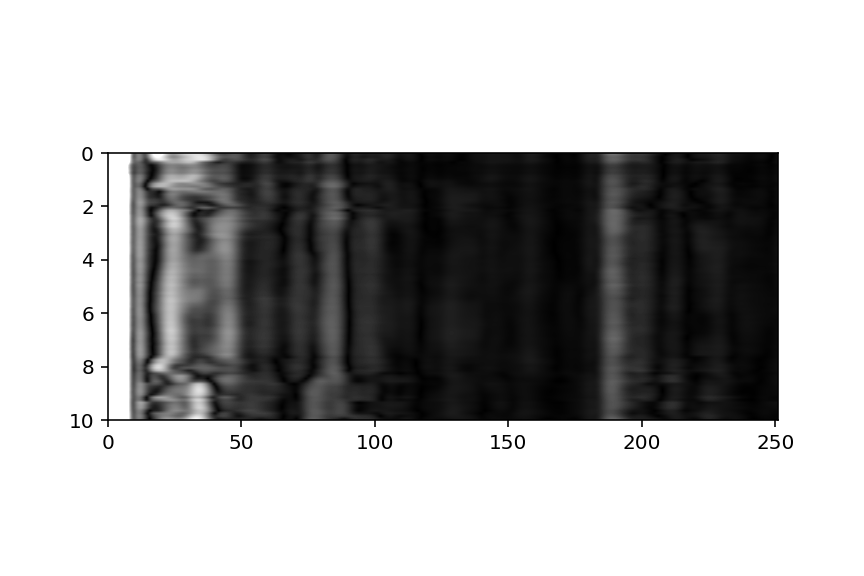

In [131]:
%matplotlib notebook

# display up to 2.5m approximately 700 samples at 21 degrees C in 48000 sampling rate

vmax = 0.3 # threshold -- lower will be able to see smaller echos

plt.imshow(img[:,0:700]/max(img.ravel()),vmax=0.2, aspect=10,cmap='gray',interpolation='bilinear',extent=(0,time2dist(700/48000),Nrep*Nseg/fs,0))


#### Observation
As I move close to my laptop, the echoes appear very quickly, as I leave far away from the laptop, the echoes appear slowly.

### Proceed to the Real-Time Sonar Lab